# 3次関数の回帰問題をベイズ推論で解く(pandasデータフレームのデータを学習する,データフレームに定数項を含めない)
PyMCの実例を見ると,そのほとんどがNumPy配列の変数を使用しています.
データサイエンスの現場ではPandasデータフレーム形式でデータを扱うことが多いので,このノートブックでは,Pandasのデータを極力変換することなく学習に使用することを試してみます.

最初に,必要なライブラリをインポートします.

In [1]:
import arviz as az
import numpy as np
import pymc as pm
import pytensor.tensor as pt

import pandas as pd

import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
%matplotlib inline

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


グラフのスタイルや乱数の種を初期化します.

In [2]:
az.style.use("arviz-darkgrid")

RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## 問題設定
今回も,$y = \frac{x^3}{3} - x$に正規分布のノイズを加えたデータセットの回帰問題に挑戦します.

データの分布を図1に示します.

,x,x2,x3,y
0,-2.500000,6.250000,-15.625000,-2.860371
1,-2.474874,6.125003,-15.158613,-2.998314
2,-2.449749,6.001269,-14.701601,-2.612736


(-3.0, 3.0)

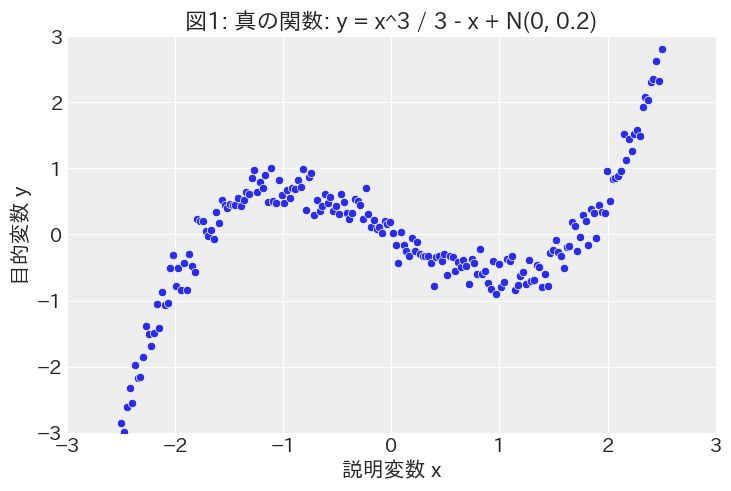

In [3]:
x = np.linspace(-2.5, +2.5, 200)
noise = np.random.normal(loc = 0.0, scale = 0.2, size = x.shape[0])
y = x ** 3 / 3.0 - x + noise

df = pd.DataFrame({
    "x": x,
    "x2": x ** 2,
    "x3": x ** 3,
    "y": y
})
del x, y, noise# 誤って使わないように削除する.

display(df.head(n = 3))


sns.scatterplot(data = df, x = "x", y = "y")

plt.title("図1: 真の関数: y = x^3 / 3 - x + N(0, 0.2)")
plt.xlabel("説明変数 x")
plt.ylabel("目的変数 y")
plt.xlim(-3, 3)
plt.ylim(-3, 3)

データセット全体のうち,$x < 1$のデータを訓練データセット, $x \geq 1$のデータをテストデータセットとします.
今回の問題は,$x < 1$のデータを用いて,$x \geq 1$の目的変数を予測することとなります.

図2は訓練データセットの散布図です.
切り取られた右端のデータセットを予測することが,今回の課題になります.

(-3.0, 3.0)

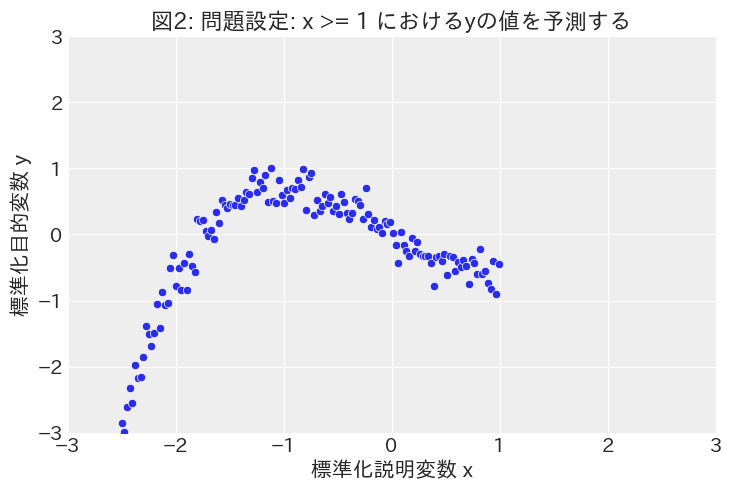

In [4]:
train_X, train_y = df[ df["x"] < 1][["x", "x2", "x3"]], df[ df["x"] < 1]["y"]
test_X, test_y = df[ df["x"] >= 1][["x", "x2", "x3"]], df[ df["x"] >= 1]["y"]

sns.scatterplot(x = train_X["x"], y = train_y)
plt.title("図2: 問題設定: x >= 1 におけるyの値を予測する")
plt.xlabel("標準化説明変数 x")
plt.ylabel("標準化目的変数 y")
plt.xlim(-3, 3)
plt.ylim(-3, 3)

## モデル定義
タイトルに答えが書いてありますが,一応3次関数でモデルを作成する理由を書いておきましょう.

1. 散布図のピークが1つだけ見えるので,2次関数か3次関数で近似するのが無難.
1. 標準化したデータの散布図が線対称ではないので,3次関数を選択する.
    * $x = -1.5, 1.5$の目的変数の値が倍違う.

したがって,今回の確率モデルは下記の式で表されます.
$$
\begin{align}
y &\sim \mathcal{N} \bigl( \mu , \sigma ^2 \bigr)\\
\mu &= \alpha + \beta _0 x + \beta _1 x^2 + \beta _1 x^3\\
\sigma &\sim \mathcal{HN} \bigl(1)\\
\alpha &\sim \mathcal{N} \bigl( 0 , 1)\\
\beta _i &\sim \mathcal{N} \bigl( 0 , 1)
\end{align}
$$

ここで,$\alpha$は3次関数の切片,$\beta _i$は係数です.
$\alpha$と$\beta _i$は標準正規分布,$\sigma$標準半正規分布と仮定します(事前分布).
この確率モデルをプログラミングすると,次のセルの通りになります.

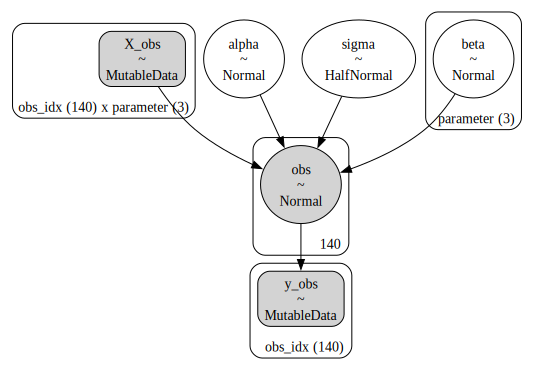

In [5]:
# モデル定義
with pm.Model(coords_mutable = {"obs_idx": np.arange(len(train_X))}, coords = {"parameter": train_X.columns}) as model:
    # 観測値
    X_obs = pm.MutableData("X_obs", value = train_X, dims = ["obs_idx", "parameter"])
    y_obs = pm.MutableData("y_obs", value = train_y, dims = ["obs_idx"])

    # 3次関数の係数
    alpha = pm.Normal("alpha", mu = 0, sigma = 1)
    beta = pm.Normal("beta", mu = 0, sigma = 1, dims = ["parameter"])

    # 目的変数の誤差の確率分布
    mu = alpha + pt.dot(X_obs, beta)
    sigma = pm.HalfNormal("sigma", sigma = 1)
    pm.Normal("obs", mu = mu, sigma = sigma, observed = y_obs)

# モデル構造の可視化
pm.model_to_graphviz(model)

### 事後分布の生成
モデル構造が設計どおりであることを確認したら,次はMCMCに基づく事後分布の生成を行います.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 25 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

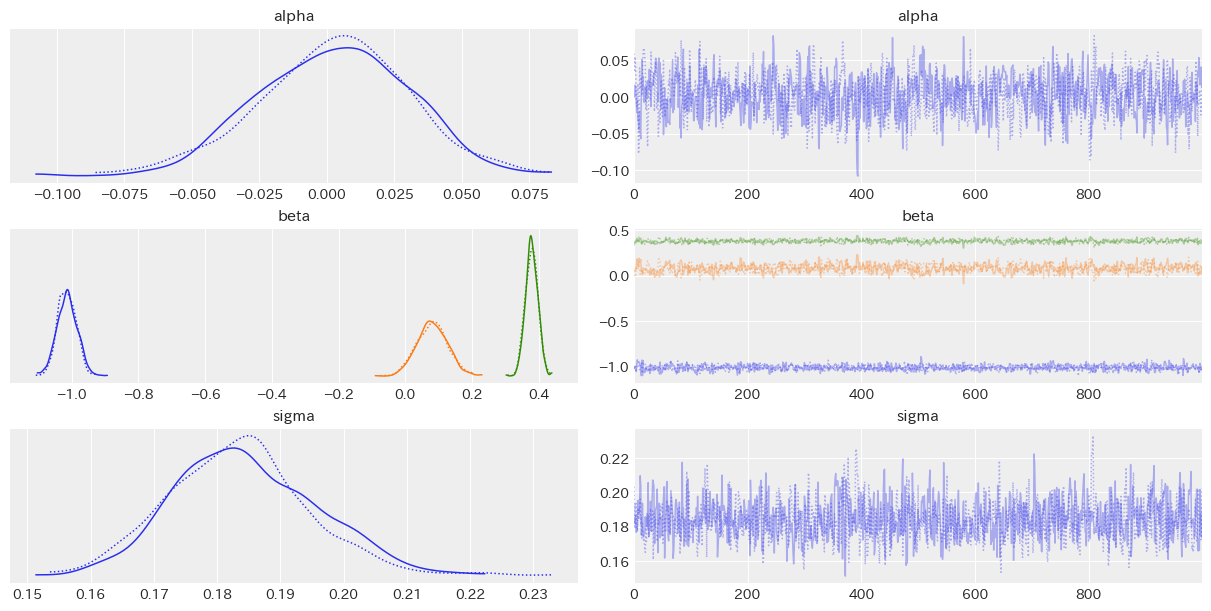

In [6]:
with model:
    # 事後分布の生成
    idata = pm.sample(draws = 1000, tune = 1000, chains = 2, target_accept = 0.95, random_seed = rng)

# サンプリングトレースの可視化
az.plot_trace(idata)

サンプリングトレースが問題ないことを確認したら,モデルの評価に移ります.

判断基準
* 左側の分布が1箇所に収束している.
    * ただし,予測値$\mu$の分布は無視する.
* 右側の分布に黒い縦線(発散)が無い.

## モデルの評価
次の2種類の分布から,モデルを評価します.
1. パラメータ推定値の分布
1. 目的変数-予測値の分布

まずは,パラメータ推定値の分布を可視化します.

array([<Axes: title={'center': '94.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

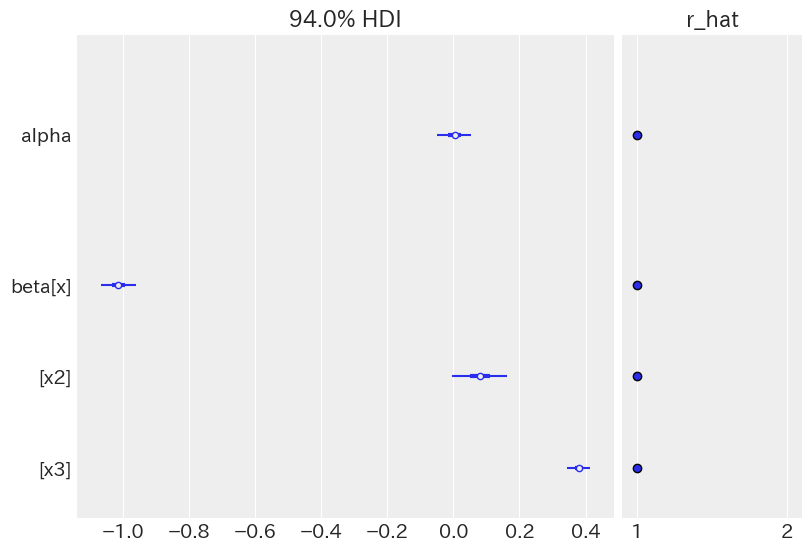

In [7]:
az.plot_forest(idata, combined = True, var_names = ["alpha", "beta"], r_hat = True)

```r_hat```が1に近いとパラメータ推定は安定していると考えられます.

また,パラメータ推定値は真の関数$y = \frac{x^3}{3} - x$の係数とほぼ同じ値を指しました.

次は目的変数-予測値の分布を可視化したいのですが,最後の予測値の可視化でエラーが発生するので,コメントアウトします.

In [8]:
#with model:
    # 予測値の計算
#    idata.extend(pm.sample_posterior_predictive(idata))

# 予測値分布の可視化
#az.plot_ppc(idata, num_pp_samples = 10)

## データの予測
```pm.MutableData```に観測値を登録することで,**モデルを書き写さないで予測値を算出できます**.

モデルが複雑になるとコピペミスが発生しやすいので,コピペしないで済む機能は便利です.

In [9]:
with model:
    # テストデータの登録
    pm.set_data(
        {
            "X_obs": test_X,
            # 目的変数にはダミーデータを登録する
            'y_obs': np.zeros(len(test_X))
        },
        coords = {"obs_idx": np.arange(len(test_X)) + len(train_X)}
    )

    # 予測値の計算
    idata.extend(pm.sample_posterior_predictive(idata, extend_inferencedata = True))

Sampling: [obs]


<Axes: xlabel='obs'>

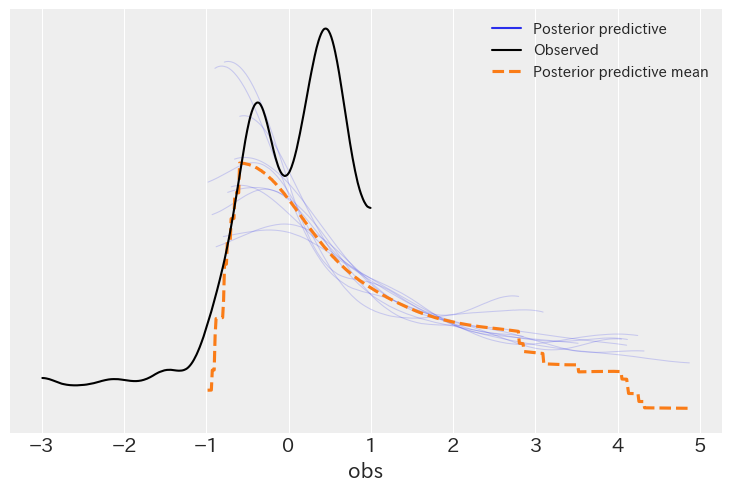

In [10]:
# 予測値の分布
az.plot_ppc(idata, num_pp_samples = 10)

テストデータの予測値をプロットします.

Text(0, 0.5, '標準化目的変数 y')

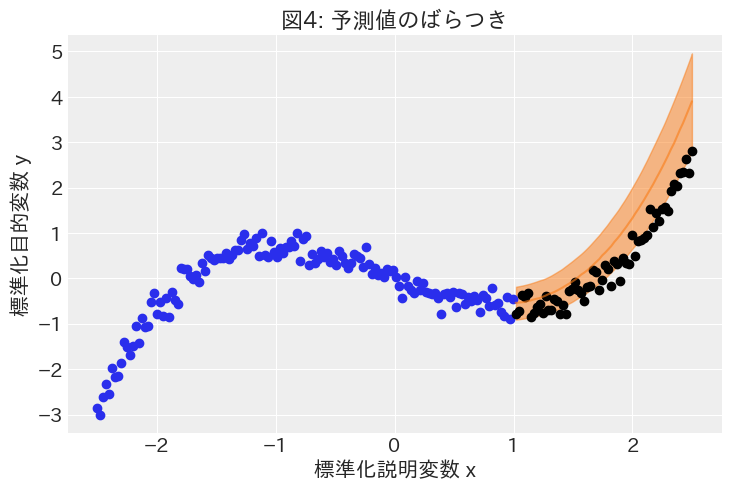

In [11]:
_, ax = plt.subplots()

# 予測値の平均値
ax.plot(
    test_X["x"], idata.posterior_predictive["obs"].mean(("chain", "draw")),
    label = "Mean outcome", color = "C1", alpha = 0.6
)
# 予測値のばらつき
az.plot_hdi(test_X["x"], idata.posterior_predictive["obs"])
# 訓練データ
ax.scatter(train_X["x"], train_y)
ax.scatter(test_X["x"], test_y, marker = "o", color = "k")


ax.set_title("図4: 予測値のばらつき")
ax.set_xlabel("標準化説明変数 x")
ax.set_ylabel("標準化目的変数 y")

予測範囲にテストデータが収まっていたので、このモデルの予測は妥当だと考えられます.

3次関数の場合は,スケーリングをしなくとも上手く予測できるようです.

In [12]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Sat Apr 06 2024

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

pytensor: 2.19.0

numpy              : 1.26.4
japanize_matplotlib: 1.1.3
seaborn            : 0.13.2
arviz              : 0.17.1
matplotlib         : 3.8.3
pytensor           : 2.19.0
pandas             : 2.2.1
pymc               : 5.12.0

Watermark: 2.4.3



## 参考URL
[PyMC：重回帰を題材にしたPyMCの紹介](https://zenn.dev/yoshida0312/articles/bbd246d3da42b3#%E4%BA%88%E6%B8%AC)